In [11]:
import re
import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [35]:
# start Spark Session
from pyspark.sql import SparkSession
app_name = "hw4_notebook"
master = "local[*]"
spark = SparkSession\
        .builder\
        .appName(app_name)\
        .master(master)\
        .getOrCreate()
sc = spark.sparkContext

In [36]:
FIELDS=["label","I1","I2","I3","I4","I5","I6","I7","I8","I9","I10","I11","I12","I13","C1","C2","C3","C4","C5","C6","C7","C8"
       ,"C9","C10","C11","C12","C13","C14","C15","C16","C17","C18","C19","C20","C21","C22","C23","C24","C25","C26"]

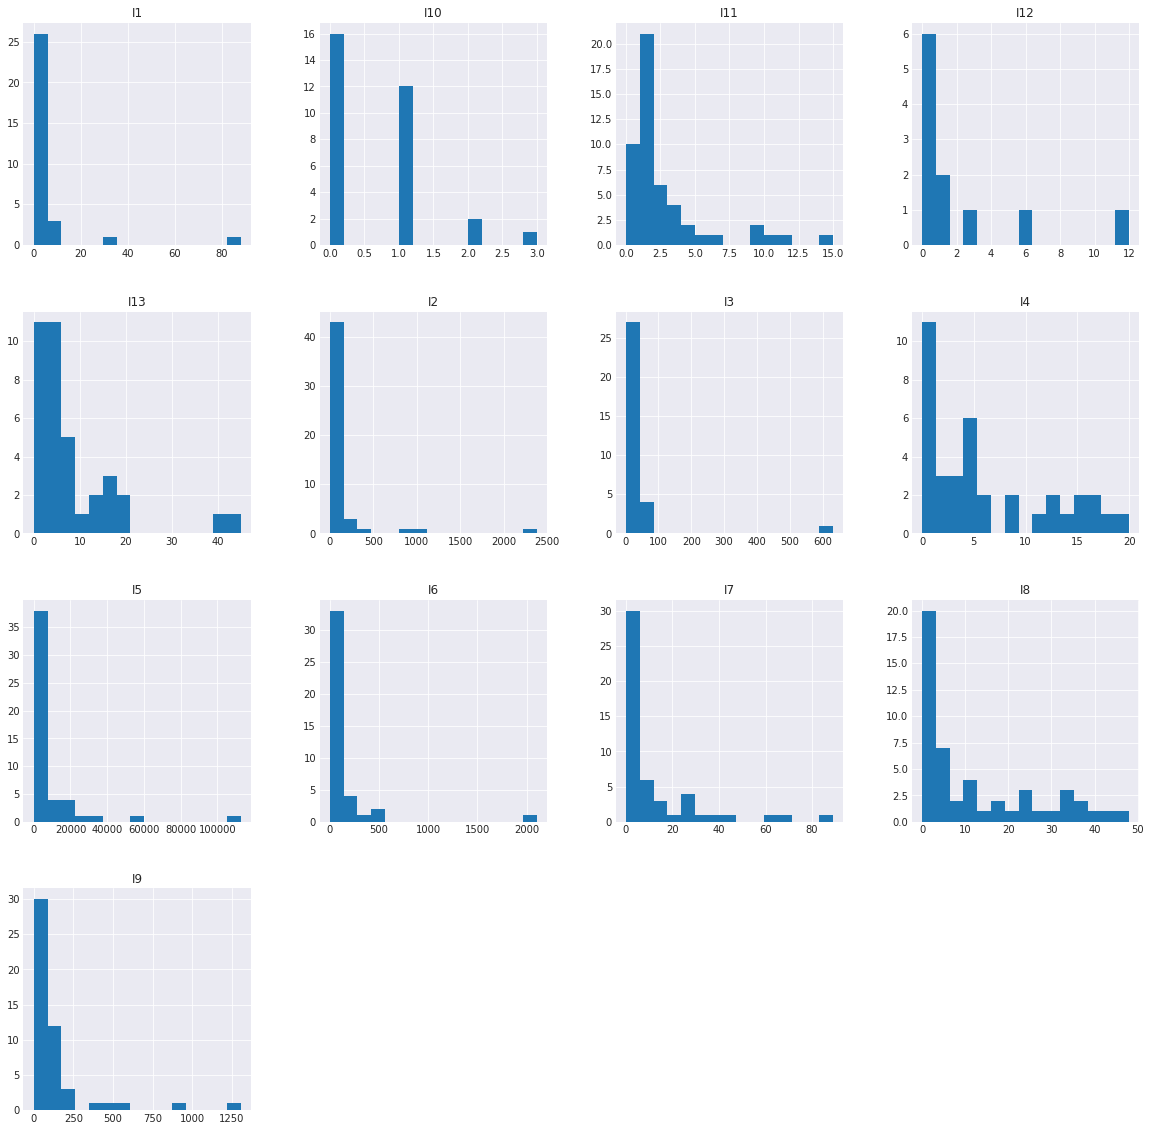

In [37]:
myfile = "data/toy_example.txt"
pDF = pd.read_csv(myfile,sep='\t',names=FIELDS)
pDF[FIELDS[1:14]].hist(figsize=(20,20), bins=15)
plt.show()

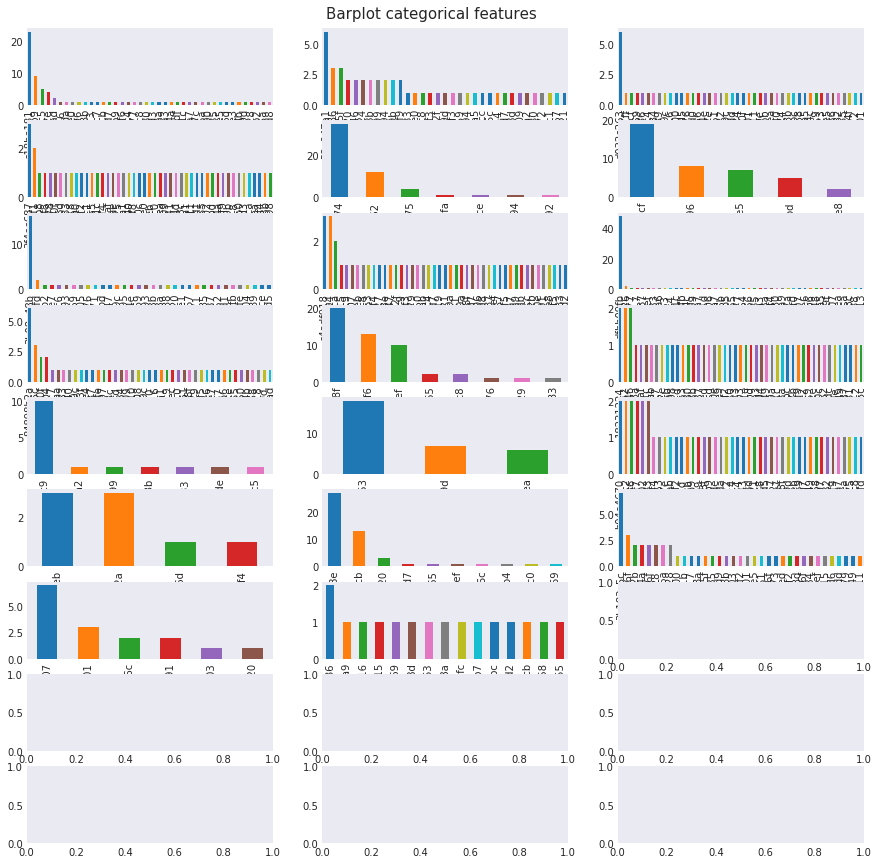

In [15]:
fig, ax_grid = plt.subplots(9, 3, figsize=(15,15))
for idx, feature in enumerate(FIELDS[14:]):
    x = pDF[feature].value_counts()
    #sns.barplot(x, ax=ax_grid[idx//8][idx%3], orient='h', linewidth=.5)
    x.plot(kind='bar',ax=ax_grid[idx//4][idx%3])
    ax_grid[idx//4][idx%3]
fig.suptitle("Barplot categorical features", fontsize=15, y=0.9)
plt.show()

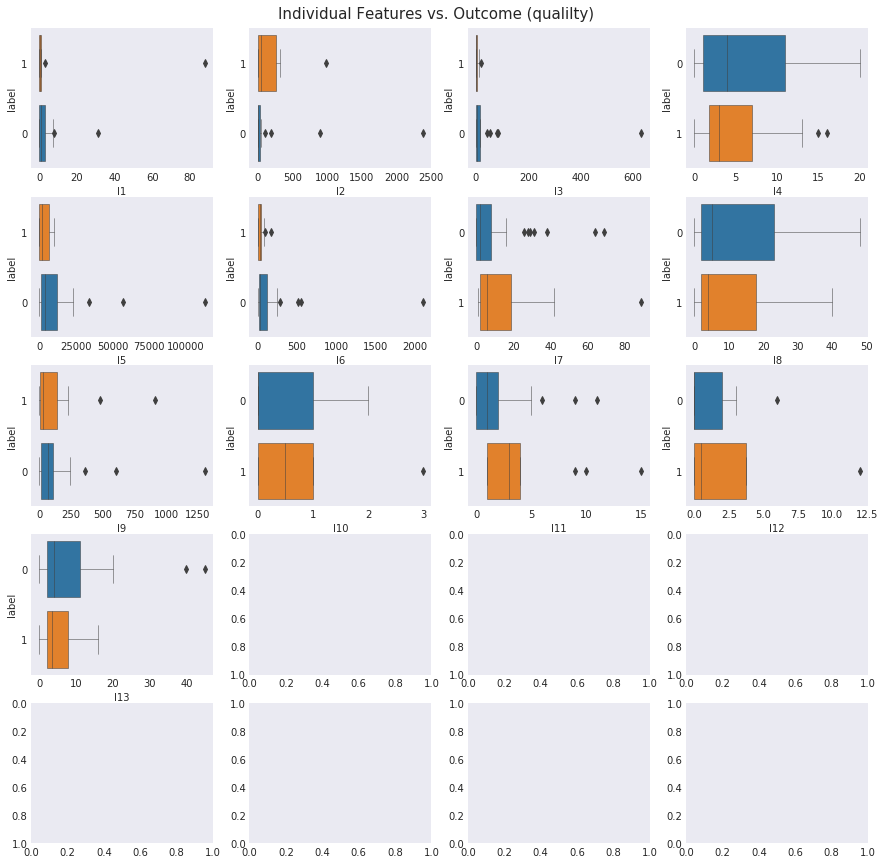

In [21]:
fig, ax_grid = plt.subplots(5, 4, figsize=(15,15))
y =  pDF['label']
for idx, feature in enumerate(FIELDS[1:14]):
    x = pDF[feature]
    sns.boxplot(x, y, ax=ax_grid[idx//4][idx%4], orient='h', linewidth=.5)
    ax_grid[idx//3][idx%4].invert_yaxis()
fig.suptitle("Individual Features vs. Outcome (qualilty)", fontsize=15, y=0.9)
plt.show()

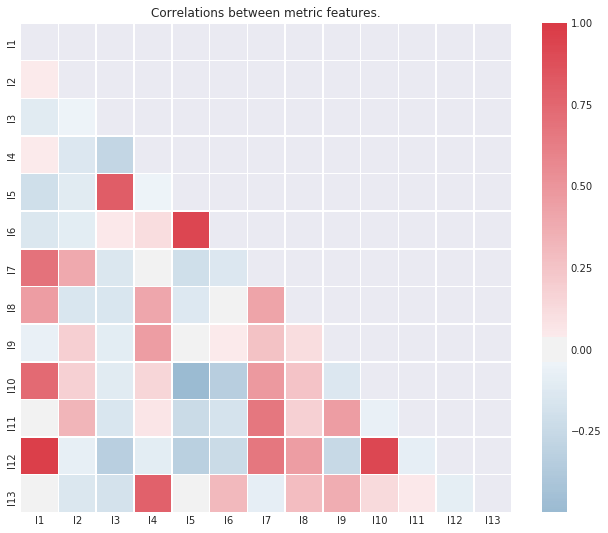

In [84]:
corr = pDF[FIELDS[1:14]].corr()
fig, ax = plt.subplots(figsize=(11, 9))
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
cmap = sns.diverging_palette(240, 10, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, center=0, linewidths=.5)
plt.title("Correlations between metric features.")
plt.show()

In [38]:
rdd = sc.textFile(myfile).map(lambda k: k.split('\t'))
df = rdd.toDF(FIELDS)
TARGET = FIELDS[0]
METRIC_FEATURES = FIELDS[1:14]
CAT_FEATURES = FIELDS[14:]

##Scaling Metric Features

In [39]:
from pyspark.sql.functions import min, max, col, lit,when,udf
from pyspark.sql.types import DoubleType

tmpDF = df
for feature in METRIC_FEATURES:
    tmpDF = tmpDF.na.fill({feature: '0'})
    tmpDF = tmpDF.withColumn(feature,when(col(feature) == '', lit(0)).otherwise(col(feature).cast(DoubleType())))
    featureStats = tmpDF.agg(min(col(feature)), max(col(feature))).collect()
    max_value = featureStats[0][1]
    min_value = featureStats[0][0]
    udf_myFunction = udf(lambda z: (z - min_value) / (max_value - min_value), DoubleType())
    tmpDF = tmpDF.withColumn(feature, udf_myFunction(col(feature))) 
df = tmpDF

##Dummyfying Categorical Features

In [40]:
tmpDF = df
for feature in CAT_FEATURES:
    featureValues = df.select(col(feature)).distinct().collect()
    for featureValue in featureValues:
        featureValue = featureValue[0]
        newColName = feature + "_" + featureValue
        tmpDF = tmpDF.withColumn(newColName,when(col(feature) == featureValue, lit(1)).otherwise(lit(0)))
        
tmpDF = tmpDF.drop(*FIELDS[14:])
df = tmpDF        

In [41]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.types import IntegerType

df = df.withColumn("label", col("label").cast(IntegerType())) 
assembler = VectorAssembler(
    inputCols = df.columns[1:],
    outputCol="features")

output = assembler.transform(df)
df = output.select("features", "label")


lr = LogisticRegression(maxIter=10, regParam=0.3, elasticNetParam=0.8)
lrModel = lr.fit(df)

# Print the coefficients and intercept for logistic regression
print("Coefficients: " + str(lrModel.coefficients))
print("Intercept: " + str(lrModel.intercept))

Coefficients: (662,[],[])
Intercept: -1.0459685551826876
